In [1]:
# Import libraries
import os
import sys
import sqlite3
from sqlalchemy import create_engine
from sqlalchemy.engine.reflection import Inspector
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

/Users/daviddapaz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Feature Engineering

In [ ]:
db = sqlite3.connect('instacart.db')
c = db.cursor()

In [ ]:
# Read CSV into SQLite database
files_list = [file  for file in os.listdir() if file.find(".csv") != -1 ]
print (files_list)

In [ ]:
for file in files_list:
        table = file.split(".")[0]
        print('\n loading table {}'.format(table))
        file_name = file
        for chunk in pd.read_csv(file_name, chunksize=10000):
            chunk.to_sql(name=table, con=db, if_exists='append', index=False )
        print('completed')
print('all tables loaded')

# Checking the database upload

In [ ]:
# Creating dataframes and checking shape
aisles = pd.read_sql_query("SELECT * FROM aisles;", db)
products = pd.read_sql_query("SELECT * FROM products;", db)
departments = pd.read_sql_query("SELECT * FROM departments;", db)
orders = pd.read_sql_query("SELECT * FROM orders;", db)
order_products__train = pd.read_sql_query("SELECT * FROM order_products__train;", db)
order_products__prior = pd.read_sql_query("SELECT * FROM order_products__prior;", db)

print('Total number of aisles: {}'.format(aisles.shape[0]))
print('Total number of products: {}'.format(products.shape[0]))
print('Total number of orders: {}'.format(orders.shape[0]))
print('Total number of order_products__train: {}'.format(order_products__train.shape[0]))
print('Total number of order_products__prior: {}'.format(order_products__prior.shape[0]))

In [ ]:
del aisles, products, departments, orders, order_products__train, order_products__prior

In [ ]:
# Create table
c.execute('''CREATE TABLE up_pairs_train AS
             SELECT substr('00'||orders.user_id, -6) || '-' || 
                 substr('0000'||order_products__train.product_id, -6) AS up_pair
             FROM order_products__train
             JOIN orders
             ON orders.order_id = order_products__train.order_id
             GROUP BY up_pair
             ORDER BY user_id ASC, product_id ASC''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE up_pairs_prior AS
             SELECT substr('00'||orders.user_id, -6) || '-' || 
                 substr('0000'||order_products__prior.product_id, -6) AS up_pair,
                 orders.user_id AS user_id, 
                 order_products__prior.product_id AS product_id,
                 orders.order_number AS order_number
             FROM order_products__prior
             JOIN orders
             ON orders.order_id = order_products__prior.order_id
             ORDER BY user_id ASC, product_id ASC''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE max_order_by_user AS
             SELECT user_id, MAX(order_number) AS max_order_number
             FROM up_pairs_prior
             GROUP BY user_id
             ORDER BY user_id ASC''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE up_pairs_prior_modified AS
             SELECT up_pairs_prior.*, 
             max_order_by_user.max_order_number,
             (1 + max_order_by_user.max_order_number - up_pairs_prior.order_number) AS order_number_rev
             FROM up_pairs_prior
             JOIN max_order_by_user
             ON max_order_by_user.user_id = up_pairs_prior.user_id''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE first_data_table AS
             SELECT up_pairs_prior_modified.up_pair AS up_pair,
                 up_pairs_prior_modified.user_id AS user_id, 
                 up_pairs_prior_modified.product_id AS product_id, 
                 CASE WHEN up_pairs_train.up_pair IS NULL THEN 0 ELSE 1 END as 'y',
                 SUM(CASE WHEN (order_number_rev <= 5) THEN 1 ELSE 0 END) AS total_buy_n5,    
                 SUM(CASE WHEN (order_number_rev <= 5) THEN 1 ELSE 0 END) / 5.0 AS total_buy_ratio_n5,                 
                 MAX(order_number_rev) AS max_order_number_rev,
                 CASE WHEN MAX(order_number_rev) > 5
                     THEN (SUM(CASE WHEN (order_number_rev <= 5) THEN 1 ELSE 0 END) / 5.0)
                     ELSE (SUM(CASE WHEN (order_number_rev <= 5) THEN 1 ELSE 0 END) /
                         (MAX(order_number_rev) * 1.0))
                     END AS order_ratio_by_chance_n5                     
             FROM up_pairs_prior_modified
             LEFT JOIN up_pairs_train ON up_pairs_train.up_pair = up_pairs_prior_modified.up_pair
             GROUP BY up_pairs_prior_modified.up_pair''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE VIEW n5_view AS
             SELECT user_id, 
                 MAX(order_number) AS order_number_n1,
                 CASE WHEN (MAX(order_number) - 1) < 1 THEN NULL 
                     ELSE (MAX(order_number) - 1) END AS order_number_n2,
                 CASE WHEN (MAX(order_number) - 2) < 1 THEN NULL 
                     ELSE (MAX(order_number) - 2) END AS order_number_n3,
                 CASE WHEN (MAX(order_number) - 3) < 1 THEN NULL 
                     ELSE (MAX(order_number) - 3) END AS order_number_n4,
                 CASE WHEN (MAX(order_number) - 4) < 1 THEN NULL 
                     ELSE (MAX(order_number) - 4) END AS order_number_n5
             FROM orders
             WHERE eval_set = 'prior'
             GROUP BY user_id''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE n5_table AS
             SELECT n5_view.user_id,
                 orders_t1.order_id AS order_id_n1,
                 orders_t2.order_id AS order_id_n2,
                 orders_t3.order_id AS order_id_n3,
                 orders_t4.order_id AS order_id_n4,
                 orders_t5.order_id AS order_id_n5,
                 orders_t1.days_since_prior_order AS days_since_prior_order_n1,
                 orders_t2.days_since_prior_order AS days_since_prior_order_n2,
                 orders_t3.days_since_prior_order AS days_since_prior_order_n3,
                 orders_t4.days_since_prior_order AS days_since_prior_order_n4,
                 orders_t5.days_since_prior_order AS days_since_prior_order_n5
             FROM n5_view
                 LEFT JOIN orders AS orders_t1
                 ON (orders_t1.user_id = n5_view.user_id
                     AND orders_t1.order_number = n5_view.order_number_n1)
                 LEFT JOIN orders AS orders_t2
                 ON (orders_t2.user_id = n5_view.user_id
                     AND orders_t2.order_number = n5_view.order_number_n2)
                 LEFT JOIN orders AS orders_t3
                 ON (orders_t3.user_id = n5_view.user_id
                     AND orders_t3.order_number = n5_view.order_number_n3)
                 LEFT JOIN orders AS orders_t4
                 ON (orders_t4.user_id = n5_view.user_id
                     AND orders_t4.order_number = n5_view.order_number_n4)
                 LEFT JOIN orders AS orders_t5
                 ON (orders_t5.user_id = n5_view.user_id
                     AND orders_t5.order_number = n5_view.order_number_n5)''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE new_table AS
             SELECT first_data_table.*,
                 n5_table.order_id_n1,
                 n5_table.order_id_n2,
                 n5_table.order_id_n3,
                 n5_table.order_id_n4,
                 n5_table.order_id_n5
             FROM first_data_table
             LEFT JOIN n5_table
             ON (n5_table.user_id = first_data_table.user_id)
             ''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE new_table_2 AS
             SELECT new_table.up_pair,
                 new_table.y,
                 new_table.total_buy_n5,
                 new_table.total_buy_ratio_n5,
                 new_table.order_ratio_by_chance_n5,                 
                 n5_table.days_since_prior_order_n1,
                 n5_table.days_since_prior_order_n2,
                 n5_table.days_since_prior_order_n3,
                 n5_table.days_since_prior_order_n4,
                 n5_table.days_since_prior_order_n5,                 
                 CASE WHEN order_products__prior_1.product_id IS NULL THEN 0 ELSE 1 END as bought_n1,
                 CASE WHEN order_products__prior_2.product_id IS NULL THEN 0 ELSE 1 END as bought_n2,
                 CASE WHEN order_products__prior_3.product_id IS NULL THEN 0 ELSE 1 END as bought_n3,
                 CASE WHEN order_products__prior_4.product_id IS NULL THEN 0 ELSE 1 END as bought_n4,
                 CASE WHEN order_products__prior_5.product_id IS NULL THEN 0 ELSE 1 END as bought_n5
             FROM new_table
             LEFT JOIN n5_table
                 ON (n5_table.user_id = new_table.user_id)
             LEFT JOIN order_products__prior AS order_products__prior_1
                 ON (order_products__prior_1.order_id = new_table.order_id_n1
                     AND order_products__prior_1.product_id = new_table.product_id)
             LEFT JOIN order_products__prior AS order_products__prior_2
                 ON (order_products__prior_2.order_id = new_table.order_id_n2
                     AND order_products__prior_2.product_id = new_table.product_id)
             LEFT JOIN order_products__prior AS order_products__prior_3
                 ON (order_products__prior_3.order_id = new_table.order_id_n3
                     AND order_products__prior_3.product_id = new_table.product_id)
             LEFT JOIN order_products__prior AS order_products__prior_4
                 ON (order_products__prior_4.order_id = new_table.order_id_n4
                     AND order_products__prior_4.product_id = new_table.product_id)
             LEFT JOIN order_products__prior AS order_products__prior_5
                 ON (order_products__prior_5.order_id = new_table.order_id_n5
                     AND order_products__prior_5.product_id = new_table.product_id)
             ''')

# Save (commit) the changes
db.commit()

In [ ]:
# Create table
c.execute('''CREATE TABLE new_table_3 AS
             SELECT up_pair, 
                 y, 
                 total_buy_n5, 
                 total_buy_ratio_n5, 
                 order_ratio_by_chance_n5,                 
                 
                 MAX(IFNULL(order_days_n1, 0), 
                     IFNULL(order_days_n2, 0),
                     IFNULL(order_days_n3, 0),
                     IFNULL(order_days_n4, 0),
                     IFNULL(order_days_n5, 0)) AS useritem_order_days_max_n5,
                     
                 CASE WHEN days_since_prior_order_n5 IS NULL THEN
                     MIN(IFNULL(order_days_n1, 1000000), 
                         IFNULL(order_days_n2, 1000000),
                         IFNULL(order_days_n3, 1000000),
                         IFNULL(order_days_n4, 1000000),
                         MAX(IFNULL(order_days_n1, 0), 
                             IFNULL(order_days_n2, 0),
                             IFNULL(order_days_n3, 0),
                             IFNULL(order_days_n4, 0),
                             IFNULL(order_days_n5, 0)))  
                     ELSE
                     MIN(IFNULL(order_days_n1, 1000000), 
                         IFNULL(order_days_n2, 1000000),
                         IFNULL(order_days_n3, 1000000),
                         IFNULL(order_days_n4, 1000000),
                         order_days_n5)
                     END AS useritem_order_days_min_n5

             FROM 
             (
                 SELECT *,
                     CASE WHEN bought_n1 = 0 THEN NULL
                         ELSE days_since_prior_order_n1
                         END AS order_days_n1,
                 
                     CASE WHEN bought_n2 = 0 THEN NULL
                         ELSE CASE WHEN bought_n1 = 0 THEN
                             (days_since_prior_order_n1 + days_since_prior_order_n2)
                             ELSE days_since_prior_order_n2
                             END
                         END AS order_days_n2,
                 
                     CASE WHEN bought_n3 = 0 THEN NULL
                         ELSE 
                         CASE WHEN bought_n2 = 0 THEN 
                             CASE WHEN bought_n1 = 0 THEN
                                 (days_since_prior_order_n1 + days_since_prior_order_n2 +
                                 days_since_prior_order_n3)
                                 ELSE (days_since_prior_order_n2 + days_since_prior_order_n3) 
                                 END                    
                             ELSE days_since_prior_order_n3
                             END
                         END AS order_days_n3,
                         
                     CASE WHEN bought_n4 = 0 THEN NULL
                         ELSE 
                         CASE WHEN bought_n3 = 0 THEN
                             CASE WHEN bought_n2 = 0 THEN
                                 CASE WHEN bought_n1 = 0 THEN
                                     (days_since_prior_order_n1 + days_since_prior_order_n2 +
                                         days_since_prior_order_n3 + days_since_prior_order_n4)
                                     ELSE (days_since_prior_order_n2 + days_since_prior_order_n3 +
                                         days_since_prior_order_n4) 
                                     END                    
                                 ELSE (days_since_prior_order_n3 + days_since_prior_order_n4)
                                 END
                             ELSE days_since_prior_order_n4
                             END
                         END AS order_days_n4,
                         
                     CASE WHEN bought_n4 = 0 THEN
                         CASE WHEN bought_n3 = 0 THEN
                             CASE WHEN bought_n2 = 0 THEN
                                 CASE WHEN bought_n1 = 0 THEN
                                     (days_since_prior_order_n1 + days_since_prior_order_n2 +
                                         days_since_prior_order_n3 + days_since_prior_order_n4 + 
                                         IFNULL(days_since_prior_order_n5, 0))
                                     ELSE (days_since_prior_order_n2 + days_since_prior_order_n3 +
                                         days_since_prior_order_n4 + 
                                         IFNULL(days_since_prior_order_n5, 0)) 
                                     END                    
                                 ELSE (days_since_prior_order_n3 + days_since_prior_order_n4 + 
                                     IFNULL(days_since_prior_order_n5, 0))
                                 END
                             ELSE (days_since_prior_order_n4 + IFNULL(days_since_prior_order_n5, 0))
                             END
                         ELSE IFNULL(days_since_prior_order_n5, 0)
                         END AS order_days_n5
             
                 FROM new_table_2
             )
             GROUP BY up_pair
             ''')

# Save (commit) the changes
db.commit()

In [ ]:
db_url = "sqlite:///instacart.db"
engine = create_engine(db_url)

In [ ]:
# Create a list of column names
col_names = [x['name'] for x in Inspector.from_engine(engine).get_columns('new_table_3')]
col_names

In [ ]:
# Create the csv file that will contain the final, processed Instacart data
data = c.execute("SELECT * FROM new_table_3")
with open('output_file.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(col_names)
    writer.writerows(data)

# Machine Learning

In [2]:
df = pd.read_csv('output_file.csv', index_col=0)
df.head(10)

,y,total_buy_n5,total_buy_ratio_n5,order_ratio_by_chance_n5,useritem_order_days_max_n5,useritem_order_days_min_n5
up_pair,,,,,,
001-000196,1,5,1.0,1.0,30.0,0.0
001-010258,1,5,1.0,1.0,30.0,0.0
001-010326,0,0,0.0,0.0,83.0,83.0
001-012427,0,5,1.0,1.0,30.0,0.0
001-013032,1,2,0.4,0.4,34.0,19.0
001-013176,0,0,0.0,0.0,83.0,83.0
001-014084,0,0,0.0,0.0,83.0,83.0
001-017122,0,0,0.0,0.0,83.0,83.0
001-025133,1,5,1.0,1.0,30.0,0.0


In [3]:
df.shape

(13307953, 6)

In [4]:
X = df.drop('y', axis=1).values
y = df['y'].values

# Splitting the data
from sklearn.model_selection import train_test_split

# Due to computing constraints we have to reduce the data
#X_to_use, X_not_used, y_to_use, y_not_used = train_test_split(X, y,train_size=0.2,test_size=0.8)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,test_size=0.2)

# checking the shapes
#print('X_to_use:', X_to_use.shape, X_to_use.dtype)
#print('y_to_use:', y_to_use.shape, y_to_use.dtype)
print('X_train:', X_train.shape, X_train.dtype)
print('y_train:', y_train.shape, y_train.dtype)
print('X_test:', X_test.shape, X_test.dtype)
print('y_test:', y_test.shape, y_test.dtype)

X_train: (10646362, 5) float64
y_train: (10646362,) int64
X_test: (2661591, 5) float64
y_test: (2661591,) int64


# Stochastic Gradient Classifier

In [5]:
from sklearn.linear_model import SGDClassifier

# Create the estimator
sgd_clf = SGDClassifier(random_state=42)

# Fit the model to train data
sgd_clf.fit(X_train, y_train)

# Accuracy on test set
accuracy_sgd = sgd_clf.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_sgd))

Accuracy: 0.938


# Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

# Create the estimator
logreg = LogisticRegression()

# Fit the model to train data
logreg.fit(X_train, y_train)

# Accuracy on test set
accuracy_logreg = logreg.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_logreg))

Accuracy: 0.937


# Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=0)

# Fit the model to train data
dt.fit(X_train, y_train)

# Get score
accuracy_dt = dt.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_dt))

Accuracy: 0.938


In [8]:
# Increasing depth
dt_2 = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0)

# Fit the model to train data
dt_2.fit(X_train, y_train)

# Get score
accuracy_dt_2 = dt_2.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_dt_2))

Accuracy: 0.938


In [9]:
# Increasing depth
dt_3 = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

# Fit the model to train data
dt_3.fit(X_train, y_train)

# Get score
accuracy_dt_3 = dt_3.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_dt_3))

Accuracy: 0.938


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Create a decision tree
rf_1 = RandomForestClassifier(
    n_estimators=1, max_depth=5 , random_state=0)

# Fit estimator
rf_1.fit(X_train, y_train)

# Get score
accuracy_rf_1 = rf_1.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_rf_1))

Accuracy: 0.938


# Neural Networks

In [11]:
# Split again into validation/test sets

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test,
    test_size=0.1, random_state=0
)

print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (10646362, 5) (10646362,)
Validation: (2395431, 5) (2395431,)
Test: (266160, 5) (266160,)


In [12]:
import tensorflow as tf

# Create placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, 5])
y = tf.placeholder(dtype=tf.int32, shape=[None])

# Create variables
W = tf.Variable(initial_value=tf.zeros(shape=[5, 2]))
b = tf.Variable(initial_value=tf.zeros(shape=[2]))

# Compute logits
logits = tf.matmul(X, W) + b
print(logits.shape)

# Cross-entropy loss function (without one-hot encoding)
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)
print(ce.shape)

# Mean cross-entropy
mean_ce = tf.reduce_mean(ce)
print(mean_ce.shape)

# Gradient descent
lr = tf.placeholder(dtype=tf.float32, shape=[])
gd = tf.train.GradientDescentOptimizer(
    learning_rate=lr)

# Minimize cross-entropy
train_op = gd.minimize(mean_ce)

# Compute predictions
predictions = tf.argmax(
    logits, # shape: (n, 10)
    axis=1, # class with max logit
    output_type=tf.int32 # Same type as labels
)
print(predictions.shape)

# Are the predictions correct?
is_correct = tf.equal(y, predictions)
print(is_correct.shape)

# Accuracy
accuracy = tf.reduce_mean(
    # Convert booleans (false/true) to 0/1 float numbers
    tf.cast(is_correct, dtype=tf.float32)
)
print(accuracy.shape)

(?, 2)
(?,)
()
(?,)
(?,)
()


In [13]:
# Function to get batches of data
def get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i:i+batch_size], y[i:i+batch_size]

get_batches(X_train, y_train, 10000)

<generator object get_batches at 0x113c31468>

In [14]:
# Use generator in a "for" loop

for X_batch, y_batch in get_batches(X_train, y_train, 10000):
    print('Batch X/y:', X_batch.shape, y_batch.shape)

Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/

Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/

Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/y: (10000, 5) (10000,)
Batch X/

In [15]:
# Accuracy score after each batch of data
acc_values = []

# Initialization operation
initialization_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 10000):
        # Run training and evaluate accuracy
        _, batch_acc = sess.run([train_op, accuracy], feed_dict={
            X: X_batch,
            y: y_batch,
            lr: 0.1 # learning rate
        })
        acc_values.append(batch_acc)

    # Get weight matrix and biases
    W_fitted = W.eval()
    b_fitted = b.eval()
    # .. which is equivalent to
    W_fitted, b_fitted = sess.run([W, b])

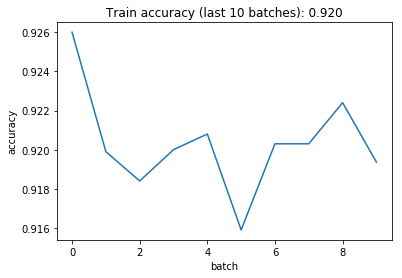

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(acc_values[-10:])
plt.title('Train accuracy (last 10 batches): {:.3f}'.format(
    # Average accuracy value
    np.mean(acc_values[-10:])
))
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()